In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import torch

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from data_modules.inrmorph import load_data
from config import get_datapath

### Evaluating Optimal Regularization Combination

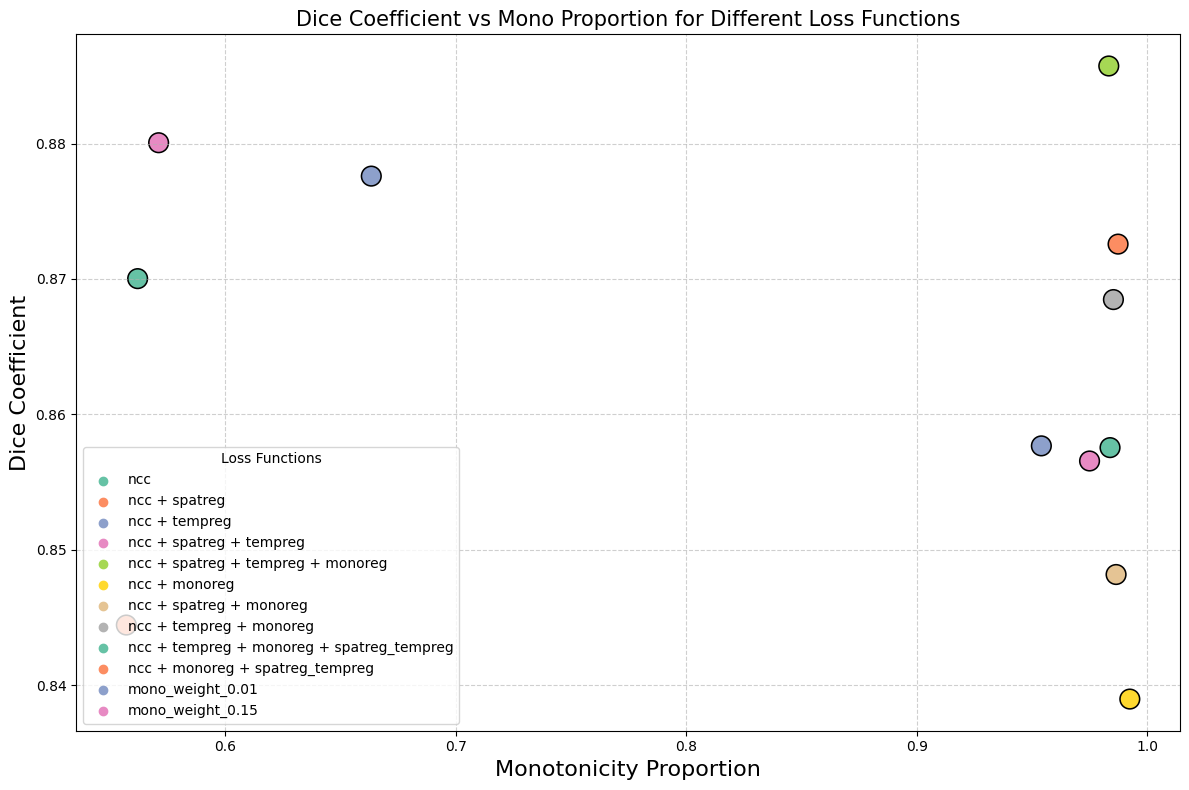

In [2]:
data = pd.read_csv('evaluating_optimal_regularization_combination.csv')
palette = sns.color_palette("Set2", n_colors=len(data['loss_functions'].unique()))
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data,
    x='mono_proportion',
    y='dice',
    hue='loss_functions',
    palette=palette, 
    s=200,  
    edgecolor='black', 
    legend='full'
)
plt.title('Dice Coefficient vs Mono Proportion for Different Loss Functions', fontsize=15)
plt.xlabel('Monotonicity Proportion', fontsize=16)
plt.ylabel('Dice Coefficient', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Loss Functions', loc='lower left', fontsize=10)
plt.tight_layout()
plt.show()


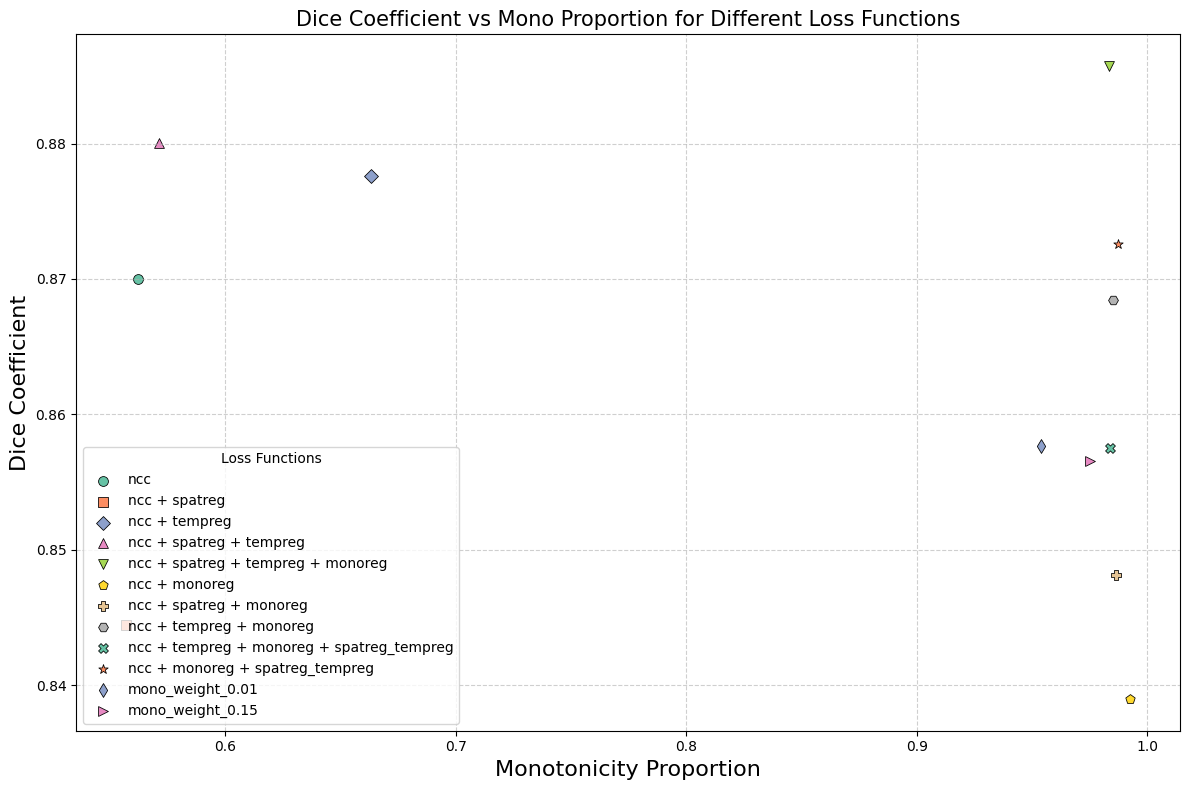

In [3]:
markers = ['o', 's', 'D', '^', 'v', 'p', 'P', 'H', 'X', '*', 'd', '>']
plt.figure(figsize=(12, 8))

#plot model type separately with different markers
for i, loss_functions in enumerate(data['loss_functions'].unique()):
    subset = data[data['loss_functions'] == loss_functions]
    sns.scatterplot(
        x=subset['mono_proportion'],
        y=subset['dice'],
        label=loss_functions,
        color=palette[i], 
        marker=markers[i], 
        s=50, 
        edgecolor='black'
    )
plt.title('Dice Coefficient vs Mono Proportion for Different Loss Functions', fontsize=15)
plt.xlabel('Monotonicity Proportion', fontsize=16)
plt.ylabel('Dice Coefficient', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Loss Functions', loc='lower left', fontsize=10)
plt.tight_layout()
plt.show()


### AD vs MCI vs CN

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset

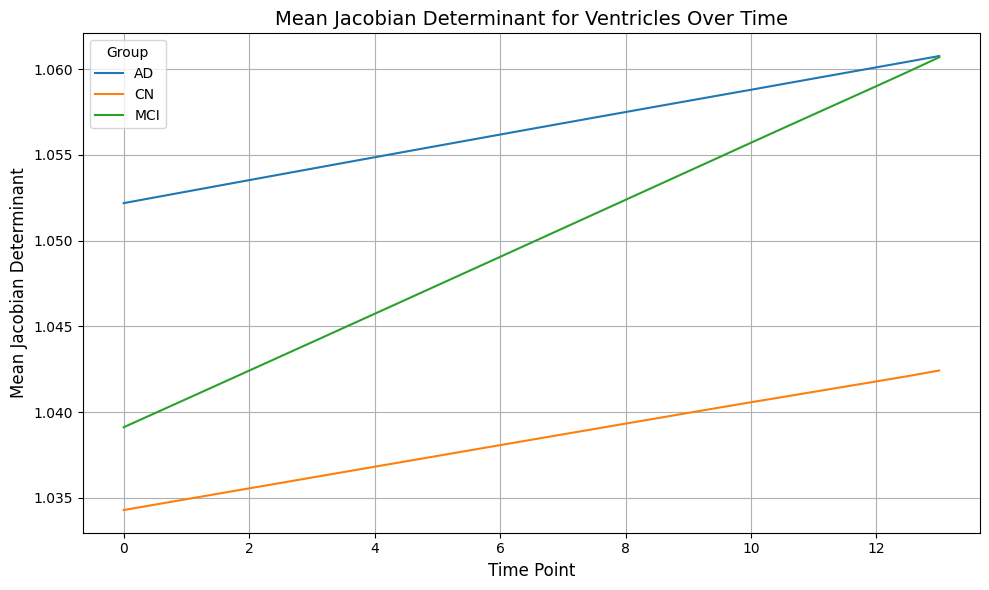

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


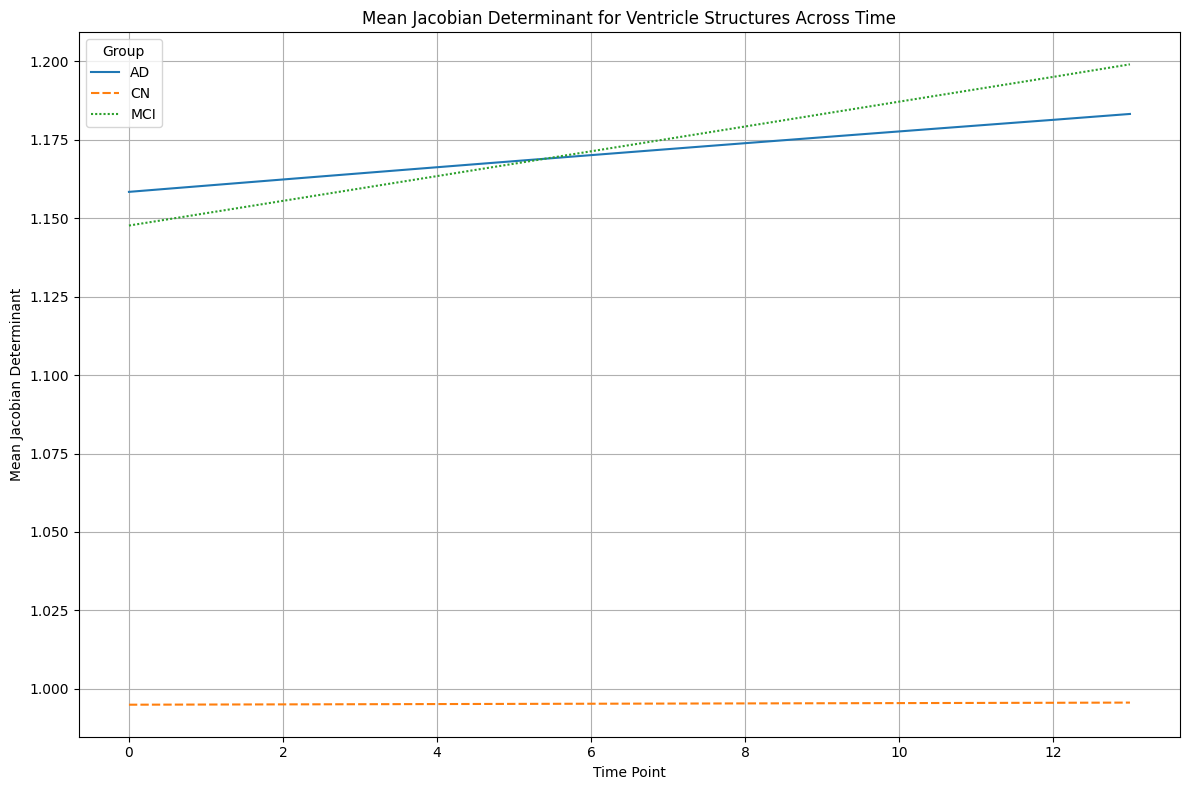

In [4]:

group_jacobian_metrics = "group_jacobian_metrics.csv"
df = pd.read_csv(group_jacobian_metrics)

ventricles_df = df[df["structure"].str.contains("ventricle", case=False)]

grouped = ventricles_df.groupby(["time_point", "group"])["jac_det_mean"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=grouped,
    x="time_point",
    y="jac_det_mean",
    hue="group",
)
plt.title("Mean Jacobian Determinant for Ventricles Over Time", fontsize=14)
plt.xlabel("Time Point", fontsize=12)
plt.ylabel("Mean Jacobian Determinant", fontsize=12)
plt.legend(title="Group", fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()


#specific subjects
ad_subjects = ["005_S_0814"]  
# mci_subjects = ["003_S_1122"]
mci_subjects = ["116_S_0361"]
cn_subjects = ["099_S_4104"]

ventricles_df = df[df["structure"].str.contains("ventricle", case=False, na=False)]
specific_subjects = ad_subjects + mci_subjects + cn_subjects
filtered_df = ventricles_df[ventricles_df["subjectID"].isin(specific_subjects)]

grouped = filtered_df.groupby(["time_point", "group", "subjectID"], as_index=False)["jac_det_mean"].mean()

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=grouped,
    x="time_point",
    y="jac_det_mean",
    hue="group",
    style="group", 
    dashes=True 
)
plt.title("Mean Jacobian Determinant for Ventricle Structures Across Time")
plt.xlabel("Time Point")
plt.ylabel("Mean Jacobian Determinant")
plt.legend(title="Group", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
#selecting subject script
ventricles_ad_df = df[(df["structure"].str.contains("ventricle", case=False)) & (df["group"] == "MCI")]
max_jac_row = ventricles_ad_df.loc[ventricles_ad_df["jac_det_mean"].idxmax()]
subject_id = max_jac_row["subjectID"]
max_jac_row["jac_det_mean"]
max_jac_row

subjectID                                   116_S_0361
time_point                                        13.0
structure                            Lateral Ventricle
structure_proportion_monotonicity             0.946159
total_proportion_monotonicity                 0.998138
jac_det_mean                                  1.199078
jac_det_min                                   0.869622
jac_det_max                                   1.655198
number_of_contractions                            1407
no_volume_change                                     0
folded_voxels                                        0
jac_det_derivative_mean                       0.004007
jac_det_derivative_min                        -0.00236
jac_det_derivative_max                        0.013839
group                                              MCI
Name: 3395, dtype: object

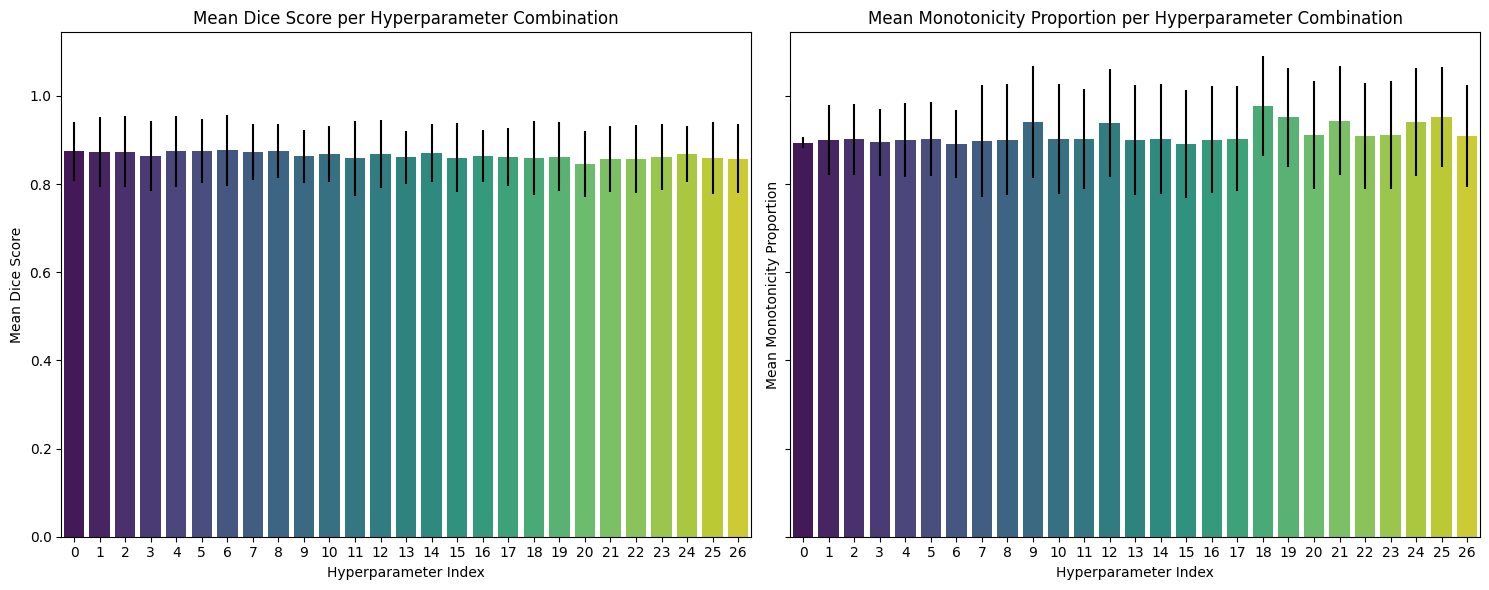

In [6]:
#cross val results
df = pd.read_csv("cross_val_results.csv")

agg_df = df.groupby('hyperparam_idx').agg({
    'structure_dice': ['mean', 'std'],
    'total_proportion_monotonicity': ['mean', 'std']
}).reset_index()

agg_df.columns = ['hyperparam_idx', 'dice_mean', 'dice_std', 'monotonicity_mean', 'monotonicity_std']

agg_df['combined_score'] = agg_df['dice_mean'] + agg_df['monotonicity_mean']
agg_df.sort_values(by='combined_score', ascending=False, inplace=True)

# print("Top hyperparameter combinations:")
# print(agg_df.head(50))
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.barplot(ax=axes[0], data=agg_df, x='hyperparam_idx', y='dice_mean', yerr=agg_df['dice_std'], palette='viridis')
axes[0].set_title('Mean Dice Score per Hyperparameter Combination')
axes[0].set_xlabel('Hyperparameter Index')
axes[0].set_ylabel('Mean Dice Score')

sns.barplot(ax=axes[1], data=agg_df, x='hyperparam_idx', y='monotonicity_mean', yerr=agg_df['monotonicity_std'], palette='viridis')
axes[1].set_title('Mean Monotonicity Proportion per Hyperparameter Combination')
axes[1].set_xlabel('Hyperparameter Index')
axes[1].set_ylabel('Mean Monotonicity Proportion')
plt.tight_layout()
plt.show()


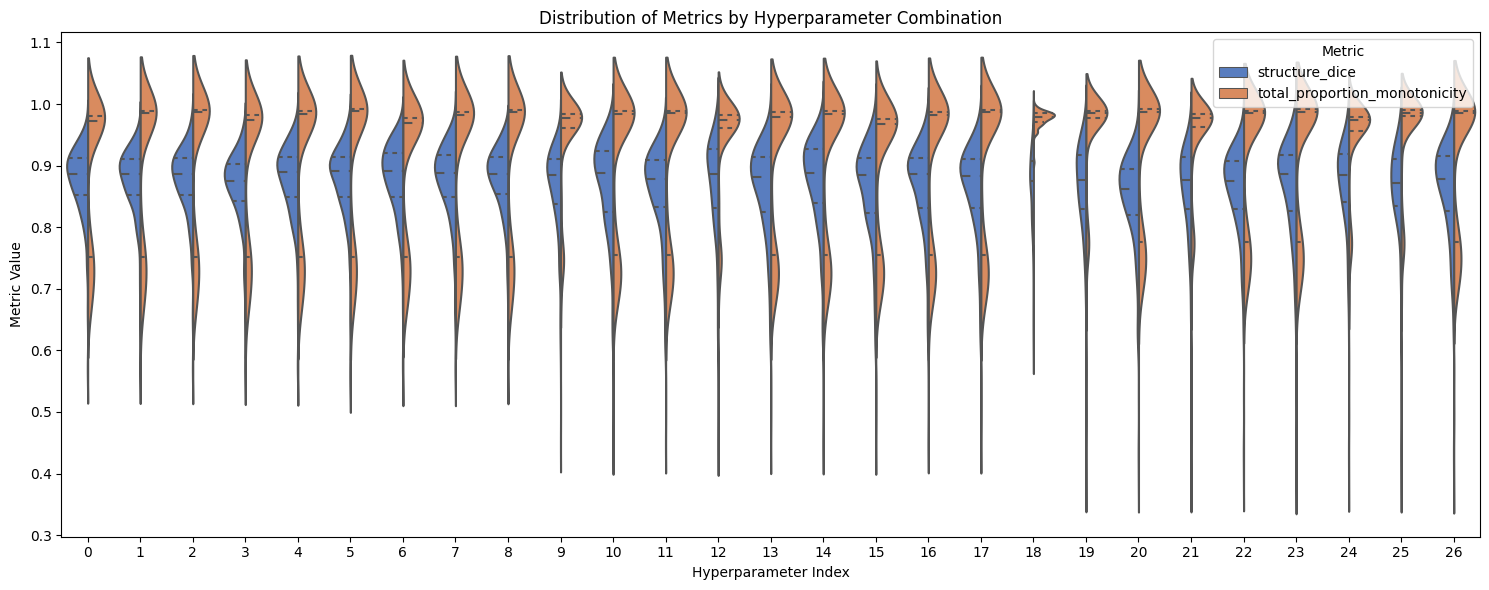

In [7]:
metrics_to_plot = ['structure_dice', 'total_proportion_monotonicity']
melted_df = df.melt(
    id_vars=['hyperparam_idx'], 
    value_vars=metrics_to_plot, 
    var_name='Metric', 
    value_name='Value'
)
plt.figure(figsize=(15, 6))

sns.violinplot(
    data=melted_df,
    x='hyperparam_idx',
    y='Value',
    hue='Metric',
    split=True, 
    inner='quartile',
    palette='muted'
)

plt.title('Distribution of Metrics by Hyperparameter Combination')
plt.xlabel('Hyperparameter Index')
plt.ylabel('Metric Value')
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()



Top Hyperparameter Combinations:
1. Best Dice Score Combination:
   Hyperparam Index: 6.0
   Spatial Reg: 0.01, Temporal Reg: 1.0, Monotonicity Reg: 0.1
   Dice Mean: 0.8764, Dice Std: 0.0657

2. Best Monotonicity Combination:
   Hyperparam Index: 19.0
   Spatial Reg: 0.1, Temporal Reg: 0.1, Monotonicity Reg: 0.5
   Monotonicity Mean: 0.5660, Monotonicity Std: 0.1968

3. Best Combined Score Combination:
   Hyperparam Index: 19.0
   Spatial Reg: 0.1, Temporal Reg: 0.1, Monotonicity Reg: 0.5
   Combined Score: 1.4287 (Dice Mean: 0.8626, Monotonicity Mean: 0.5660)


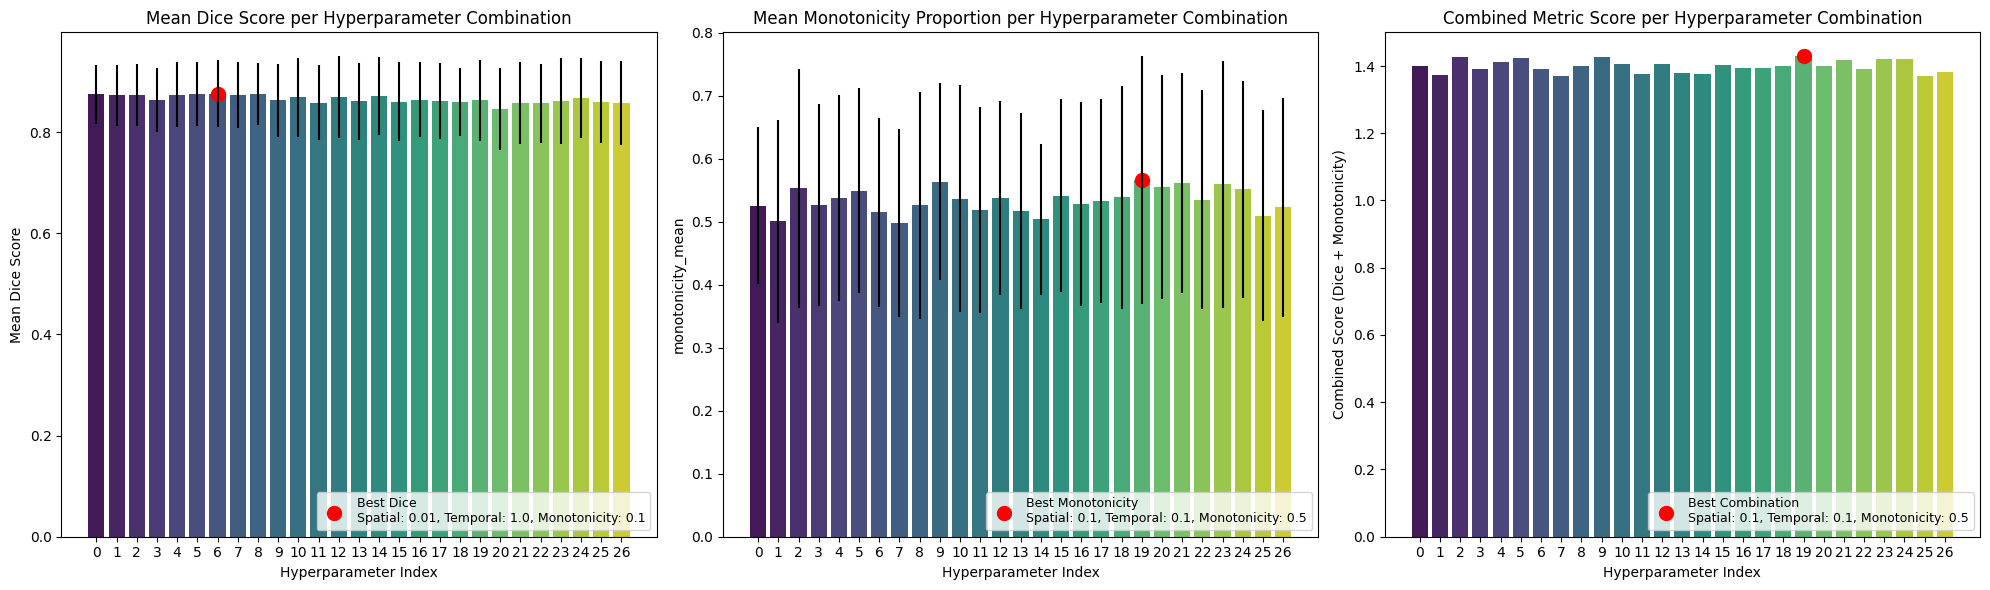

In [8]:
agg_df = df.groupby(['hyperparam_idx', 'spatial_reg', 'temporal_reg', 'monotonicity_reg']).agg({
    'structure_dice': ['mean', 'std'],
    'structure_proportion_monotonicity': ['mean', 'std']
}).reset_index()

agg_df.columns = [
    'hyperparam_idx', 'spatial_reg', 'temporal_reg', 'monotonicity_reg',
    'dice_mean', 'dice_std', 'monotonicity_mean', 'monotonicity_std'
]
highest_dice_idx = agg_df['dice_mean'].idxmax()
highest_monotonicity_idx = agg_df['monotonicity_mean'].idxmax()

highest_dice = agg_df.iloc[highest_dice_idx]
highest_monotonicity = agg_df.iloc[highest_monotonicity_idx]
agg_df['combined_score'] = agg_df['dice_mean'] + agg_df['monotonicity_mean']
best_combination_idx = agg_df['combined_score'].idxmax()
best_combination = agg_df.iloc[best_combination_idx]
print("\nTop Hyperparameter Combinations:")
print("1. Best Dice Score Combination:")
print(f"   Hyperparam Index: {highest_dice['hyperparam_idx']}")
print(f"   Spatial Reg: {highest_dice['spatial_reg']}, Temporal Reg: {highest_dice['temporal_reg']}, Monotonicity Reg: {highest_dice['monotonicity_reg']}")
print(f"   Dice Mean: {highest_dice['dice_mean']:.4f}, Dice Std: {highest_dice['dice_std']:.4f}")

print("\n2. Best Monotonicity Combination:")
print(f"   Hyperparam Index: {highest_monotonicity['hyperparam_idx']}")
print(f"   Spatial Reg: {highest_monotonicity['spatial_reg']}, Temporal Reg: {highest_monotonicity['temporal_reg']}, Monotonicity Reg: {highest_monotonicity['monotonicity_reg']}")
print(f"   Monotonicity Mean: {highest_monotonicity['monotonicity_mean']:.4f}, Monotonicity Std: {highest_monotonicity['monotonicity_std']:.4f}")

print("\n3. Best Combined Score Combination:")
print(f"   Hyperparam Index: {best_combination['hyperparam_idx']}")
print(f"   Spatial Reg: {best_combination['spatial_reg']}, Temporal Reg: {best_combination['temporal_reg']}, Monotonicity Reg: {best_combination['monotonicity_reg']}")
print(f"   Combined Score: {best_combination['combined_score']:.4f} (Dice Mean: {best_combination['dice_mean']:.4f}, Monotonicity Mean: {best_combination['monotonicity_mean']:.4f})")

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

sns.barplot(
    ax=axes[0],
    data=agg_df,
    x='hyperparam_idx',
    y='dice_mean',
    yerr=agg_df['dice_std'],
    palette='viridis'
)
axes[0].scatter(
    highest_dice['hyperparam_idx'], highest_dice['dice_mean'],
    color='red', s=100, label=(
        f"Best Dice\nSpatial: {highest_dice['spatial_reg']}, "
        f"Temporal: {highest_dice['temporal_reg']}, "
        f"Monotonicity: {highest_dice['monotonicity_reg']}"
    )
)
axes[0].set_title('Mean Dice Score per Hyperparameter Combination')
axes[0].set_xlabel('Hyperparameter Index')
axes[0].set_ylabel('Mean Dice Score')
axes[0].legend(loc='lower right', fontsize=9)

sns.barplot(
    ax=axes[1],
    data=agg_df,
    x='hyperparam_idx',
    y='monotonicity_mean',
    yerr=agg_df['monotonicity_std'],
    palette='viridis'
)
axes[1].scatter(
    highest_monotonicity['hyperparam_idx'], highest_monotonicity['monotonicity_mean'],
    color='red', s=100, label=(
        f"Best Monotonicity\nSpatial: {highest_monotonicity['spatial_reg']}, "
        f"Temporal: {highest_monotonicity['temporal_reg']}, "
        f"Monotonicity: {highest_monotonicity['monotonicity_reg']}"
    )
)
axes[1].set_title('Mean Monotonicity Proportion per Hyperparameter Combination')
axes[1].set_xlabel('Hyperparameter Index')
axes[1].legend(loc='lower right', fontsize=9)

sns.barplot(
    ax=axes[2],
    data=agg_df,
    x='hyperparam_idx',
    y='combined_score',
    palette='viridis'
)
axes[2].scatter(
    best_combination['hyperparam_idx'], best_combination['combined_score'],
    color='red', s=100, label=(
        f"Best Combination\nSpatial: {best_combination['spatial_reg']}, "
        f"Temporal: {best_combination['temporal_reg']}, "
        f"Monotonicity: {best_combination['monotonicity_reg']}"
    )
)
axes[2].set_title('Combined Metric Score per Hyperparameter Combination')
axes[2].set_xlabel('Hyperparameter Index')
axes[2].set_ylabel('Combined Score (Dice + Monotonicity)')
axes[2].legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()


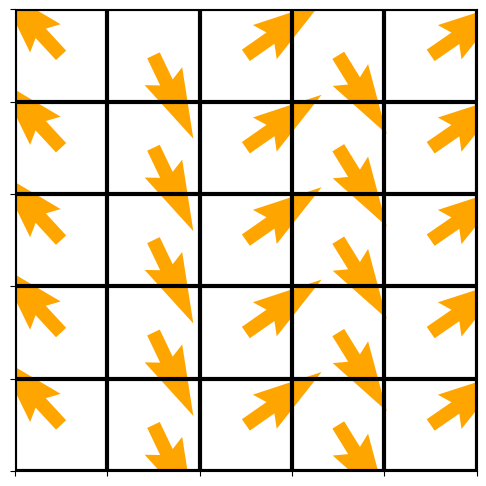

In [90]:
x = np.arange(0.5, 5) 
y = np.arange(0.5, 5)
X, Y = np.meshgrid(x, y)
U = np.zeros_like(X) 
V = np.zeros_like(Y)
for col in range(X.shape[1]):
    angle = np.random.uniform(0, 2 * np.pi)
    U[:, col] = np.cos(angle) 
    V[:, col] = np.sin(angle)  

plt.figure(figsize=(6, 6))
plt.quiver(
    X, Y, U, V, color="orange", angles="xy", scale_units="xy", scale=1.0, width=0.030
)
plt.grid(True, color="black", linestyle="-", linewidth=3) 
# plt.quiver(
#     X, Y, U, V, color="orange", angles="xy", scale_units="xy", scale=1.2, width=0.030
# )
# plt.grid(True, color="black", linestyle="-", linewidth=4) 
plt.gca().set_xticks(range(0, 6)) 
plt.gca().set_yticks(range(0, 6))  
plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([]) 
plt.gca().set_aspect("equal")
plt.show()

